In [1]:
# Imports
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit import Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map

import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm.notebook import tqdm

# Disable user warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load IBMQ account
try:
    IBMQ.load_account()
except:
    token = input("Please enter your IBMQ token: ")
    IBMQ.save_account(token)

# Load provider
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uminho-1', project='main')

# Quantum Chemistry
## Finding the minimum energy of molecules
---
Class of Quantum Computation of University of Minho (2022/2023)


#### Authors:
- Maria Gabriela Jordão Oliveira, pg50599
- Miguel Caçador Peixoto, pg50657

## Define diferent backends & devices

In [3]:
# Choose the "perfect" simulator
statevector_simulator = Aer.get_backend("statevector_simulator")

# Choose the real device
real_device = provider.get_backend('ibm_lagos')

# Create a simulator from the real device
simulator_device = AerSimulator.from_backend(real_device)

In [4]:
# Exact solver for comparison
def exact_solver(problem, converter):
    '''
    This function finds the exact solution for a given problem and converter.
    This is a pure classical solver.
    '''
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

## General Functions (Prepwork)

In [5]:
# Configure matplotlib for big font
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 18
# Increase font
plt.rcParams.update({'font.size': 16})


def get_generic_qubit_op(molecule_geometry, multiplicity, charge, basis = None, remove_orbitals=None):
    '''
    Args:
    molecule_geometry : Molecule geometry. List of lists. First element of each list is the atom name, second element is the coordinates.
    multiplicity : Multiplicity. 2*spin + 1
    charge : Charge of the molecule
    basis : Basis set. Default is sto3g
    remove_orbitals : List of orbitals to remove. Default is Non
    # Increase font
    plt.rcParams.update({'font.size': 16})e. Please unsure that the orbitals are not occupied.
    
    Returns:
    qubit_op : Qubit operator
    num_particles : Number of particles
    num_spin_orbitals : Number of spin orbitals
    problem : Problem. Electronic structure problem with driver and transformers. Freeze core transformation is used.
    converter : Converter. Qubit converter with parity mapper and two qubit reduction.
    '''
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry= molecule_geometry,
        multiplicity= multiplicity,  # = 2*spin + 1
        charge= charge,
    )

    if basis is None:
        basis = "sto3g"
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis= basis,
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True, remove_orbitals=remove_orbitals)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True )
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter


def run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, qi, quantum_instance, var_form):
    """
    Args:
    distances : List of distances
    molecule_geometry : Molecule geometry. List of lists. First element of each list is the atom name, second element is the coordinates.
    multiplicity : Multiplicity. 2*spin + 1
    charge : Charge of the molecule
    remove_orbitals : List of orbitals to remove. Default is None. Please unsure that the orbitals are not occupied.
    optimizer : Optimizer
    qi : Quantum Instance

    Returns:
    exact_energies : List of exact energies
    vqe_energies : List of vqe energies
    """

    exact_energies = []
    vqe_energies = []
    for dist in tqdm(distances, desc="Distances", leave=False, position=0):
        (qubit_op, num_particles, num_spin_orbitals, problem, converter) = get_generic_qubit_op(molecule_geometry(dist), multiplicity, charge, remove_orbitals=remove_orbitals)
        
        ######################
        ### Exact Solution ###
        ######################
        result = exact_solver(problem,converter)
        exact_energies.append(result.total_energies[0].real)

        ######################
        ### VQE Solution #####
        ######################

        # Var Form
        if var_form == "UCCSD":
            init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
            var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)
        elif var_form == "SU2":
            var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")

        # VQE
        vqe = VQE(var_form, optimizer=optimizer, quantum_instance=quantum_instance)
        vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
        vqe_energies.append(vqe_result)
        print(f"Interatomic Distance: {np.round(dist, 2)}", f"VQE Result: {vqe_result[0]:.5f}", f"Exact Energy: {exact_energies[-1]:.5f}")

    print("All energies have been calculated")
    return exact_energies, vqe_energies

def plot_energies(distances, exact_energies, vqe_energies, title):
    """
    Args:
    distances : List of distances
    exact_energies : List of exact energies
    vqe_energies : List of vqe energies
    title : Title of the plot
    """
    plt.plot(distances, exact_energies, label="Exact Energy")
    plt.plot(distances, vqe_energies, label="VQE Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy (Hartree)')
    plt.title(title)
    plt.legend()
    plt.autoscale()
    plt.grid()   
    plt.show()
    

# Simulation

## H2
Expected energy: -1.117506  hartree

Expected bond length: 0.712 Angstrom

In [6]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []
distances = np.arange(0.5, 3.0, 0.2)

### Using UCCSD ansatz and SLSQP optimizer - Perfect device

Distances:   0%|          | 0/13 [00:00<?, ?it/s]

Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.99815 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.97143 Exact Energy: -0.97143
Interatomic Distance: 1.9 VQE Result: -0.95434 Exact Energy: -0.95434
Interatomic Distance: 2.1 VQE Result: -0.94437 Exact Energy: -0.94437
Interatomic Distance: 2.3 VQE Result: -0.93892 Exact Energy: -0.93892
Interatomic Distance: 2.5 VQE Result: -0.93605 Exact Energy: -0.93605
Interatomic Distance: 2.7 VQE Result: -0.93458 Exact Energy: -0.93458
Interatomic Distance: 2.9 VQE Result: -0.93385 Exact Energy: -0.93385
All energies have been calculated


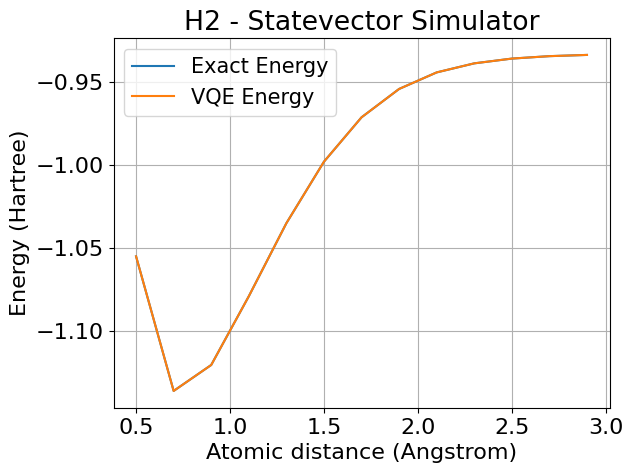

In [7]:
optimizer = SLSQP(maxiter=100)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2 - Statevector Simulator")

### Using SU2 ansatz and SPSA optimizer - Noisy simulator

Distances:   0%|          | 0/13 [00:00<?, ?it/s]

Interatomic Distance: 0.5 VQE Result: -0.96205 Exact Energy: -1.05516
Interatomic Distance: 0.7 VQE Result: -1.08124 Exact Energy: -1.13619
Interatomic Distance: 0.9 VQE Result: -1.07659 Exact Energy: -1.12056
Interatomic Distance: 1.1 VQE Result: -1.03411 Exact Energy: -1.07919
Interatomic Distance: 1.3 VQE Result: -1.00514 Exact Energy: -1.03519
Interatomic Distance: 1.5 VQE Result: -0.97321 Exact Energy: -0.99815
Interatomic Distance: 1.7 VQE Result: -0.94283 Exact Energy: -0.97143
Interatomic Distance: 1.9 VQE Result: -0.89417 Exact Energy: -0.95434
Interatomic Distance: 2.1 VQE Result: -0.91003 Exact Energy: -0.94437
Interatomic Distance: 2.3 VQE Result: -0.89742 Exact Energy: -0.93892
Interatomic Distance: 2.5 VQE Result: -0.90719 Exact Energy: -0.93605
Interatomic Distance: 2.7 VQE Result: -0.90363 Exact Energy: -0.93458
Interatomic Distance: 2.9 VQE Result: -0.90130 Exact Energy: -0.93385
All energies have been calculated


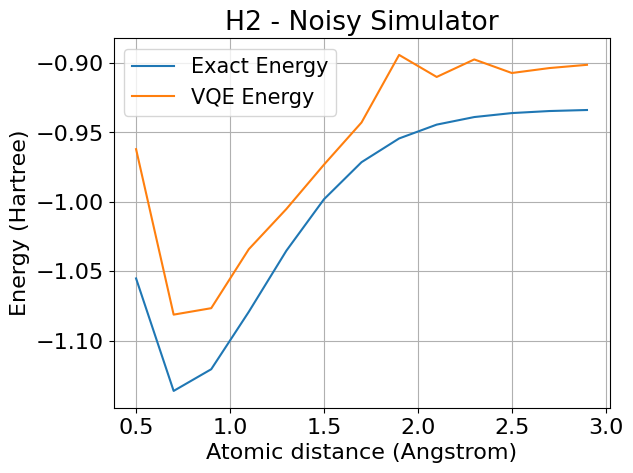

In [8]:
optimizer = SPSA(maxiter=100)
var_form = "SU2"
quantum_instance = simulator_device

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2 - Noisy Simulator")

## NaH
Expected energy: -160.315703 hartree

Expected bond length: 1.654 Angstrom

In [9]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["Na", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0

### Using UCCSD ansatz and SLSQP optimizer - Perfect device

Distances:   0%|          | 0/13 [00:00<?, ?it/s]

Interatomic Distance: 0.5 VQE Result: -158.80193 Exact Energy: -158.80193
Interatomic Distance: 0.7 VQE Result: -159.52649 Exact Energy: -159.52649
Interatomic Distance: 0.9 VQE Result: -159.92214 Exact Energy: -159.92214
Interatomic Distance: 1.1 VQE Result: -160.15700 Exact Energy: -160.15700
Interatomic Distance: 1.3 VQE Result: -160.27202 Exact Energy: -160.27202
Interatomic Distance: 1.5 VQE Result: -160.31895 Exact Energy: -160.31895
Interatomic Distance: 1.7 VQE Result: -160.32742 Exact Energy: -160.32742
Interatomic Distance: 1.9 VQE Result: -160.31400 Exact Energy: -160.31400
Interatomic Distance: 2.1 VQE Result: -160.28899 Exact Energy: -160.28899
Interatomic Distance: 2.3 VQE Result: -160.25917 Exact Energy: -160.25917
Interatomic Distance: 2.5 VQE Result: -160.22897 Exact Energy: -160.22897
Interatomic Distance: 2.7 VQE Result: -160.20114 Exact Energy: -160.20114
Interatomic Distance: 2.9 VQE Result: -160.17725 Exact Energy: -160.17725
All energies have been calculated


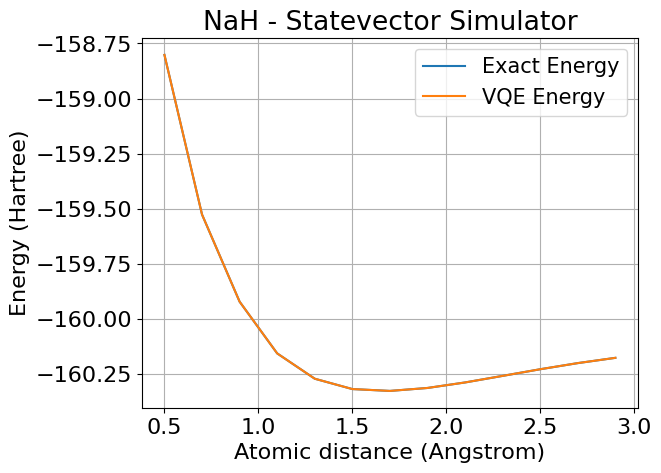

In [10]:
optimizer = SLSQP(maxiter=100)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "NaH - Statevector Simulator")

## BeH2
Expected energy: -15.561353 hartree

Expected bond length: 1.291 Angstrom

In [11]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["Be", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]],
            ["H", [-dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0

### Using UCCSD ansatz and SLSQP optimizer - Perfect device

Distances:   0%|          | 0/13 [00:00<?, ?it/s]

Interatomic Distance: 0.5 VQE Result: -13.68772 Exact Energy: -13.68826
Interatomic Distance: 0.7 VQE Result: -14.87061 Exact Energy: -14.87098
Interatomic Distance: 0.9 VQE Result: -15.36356 Exact Energy: -15.36382
Interatomic Distance: 1.1 VQE Result: -15.54905 Exact Energy: -15.54932
Interatomic Distance: 1.3 VQE Result: -15.59436 Exact Energy: -15.59471
Interatomic Distance: 1.5 VQE Result: -15.57514 Exact Energy: -15.57571
Interatomic Distance: 1.7 VQE Result: -15.52776 Exact Energy: -15.52878
Interatomic Distance: 1.9 VQE Result: -15.47112 Exact Energy: -15.47312
Interatomic Distance: 2.1 VQE Result: -15.41620 Exact Energy: -15.42019
Interatomic Distance: 2.3 VQE Result: -15.37050 Exact Energy: -15.37788
Interatomic Distance: 2.5 VQE Result: -15.33983 Exact Energy: -15.35149
Interatomic Distance: 2.7 VQE Result: -15.32410 Exact Energy: -15.34021
Interatomic Distance: 2.9 VQE Result: -15.31842 Exact Energy: -15.33693
All energies have been calculated


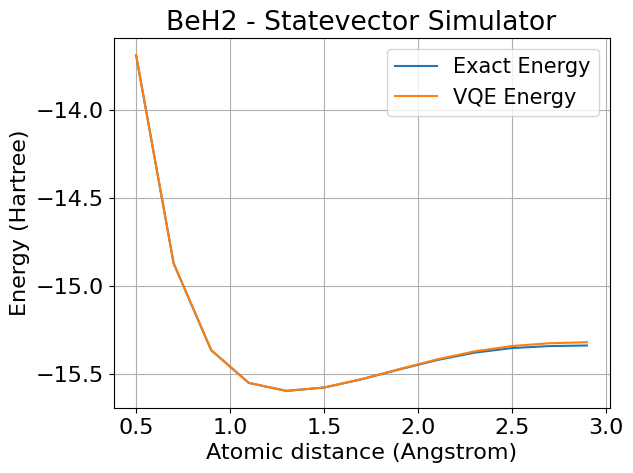

In [12]:
optimizer = SLSQP(maxiter=100)
var_form = "UCCSD"
quantum_instance = statevector_simulator

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "BeH2 - Statevector Simulator")

# Real Quantum Computer

With error mitigation

## H2

In [ ]:
raise KeyboardInterrupt # So that we don't run the following cells accidentally

In [ ]:
# Defining fixed parameters
molecule_geometry = lambda dist:[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ]
multiplicity = 1
charge = 0
remove_orbitals = []
# Reduced number of possible distances
distances = np.arange(0.5, 1.1, 0.2)

#### Defining device with error mitigation

In [ ]:
coupling_map = real_device.configuration().coupling_map
quantum_instance = QuantumInstance(
    real_device,
    measurement_error_mitigation_cls=CompleteMeasFitter
    )

#### Run on real quantum computer

We will use SU2 ansatz and SPSA optimizer

In [ ]:
optimizer = SPSA(maxiter=20)
var_form = "SU2"

# Run
exact_energies, vqe_energies = run_distances(distances, molecule_geometry, multiplicity, charge, remove_orbitals, optimizer, var_form, quantum_instance, var_form)
plot_energies(distances, exact_energies, vqe_energies, "H2 - Real Device")